In [1]:
import pandas as pd
import numpy as np
import random
import math
import itertools
import warnings
import pickle
import gc
import sys
import matplotlib.pyplot as plt
from os.path import join, exists
from collections import Counter, defaultdict
from scipy.special import gamma
from itertools import permutations, combinations, combinations_with_replacement, product
import timeit
import multiprocessing
import tqdm
import time
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, formatter={'float': lambda x: "{0:0.5f}".format(x)})
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Step 1: Load Beacon, MAF, Reference and other cached variables

In [43]:
# Replace it with the main folder
mainPath = "./data"
np.random.seed(2024)

In [14]:
# CEU Beacon - it contains 164 people in total which we will divide into groups to experiment
beacon = pd.read_csv(join(mainPath, "Beacon_164.txt"), index_col=0, delim_whitespace=True)

# Reference genome, i.e. the genome that has no SNPs, all major allele pairs for each position
reference = pickle.load(open(join(mainPath, "reference.pickle"),"rb"))

# Binary representation of the beacon; 0: no SNP (i.e. no mutation) 1: SNP (i.e. mutation)
binary = np.logical_and(beacon.values != reference, beacon.values != "NN").astype(int) 

# Table that contains MAF (minor allele frequency) values for each position. 
maf = pd.read_csv(join(mainPath, "MAF.txt"), index_col=0, delim_whitespace=True)
maf.rename(columns = {'referenceAllele':'major', 'referenceAlleleFrequency':'major_freq', 
                      'otherAllele':'minor', 'otherAlleleFrequency':'minor_freq'}, inplace = True)
maf["maf"] = np.round(maf["maf"].values, 3)


# Same variable with sorted maf values
sorted_maf = maf.sort_values(by='maf')

# Extracting column to an array for future use
maf_values = maf["maf"].values

# Prepare index arrays for future use
# beacon_people = np.arange(65)
# other_people = np.arange(99)+65
all_people = np.arange(164)

In [15]:
# MAF values are calculated from a small subset they might be 0. 
# This does not mean they are not seen in anybody in the world so we are replacing 0 MAF values with 0.001 which is a pretty rare value
maf["maf"] = maf["maf"].apply(lambda x: 0.001 if x == 0 else x)
maf_values = maf["maf"].values

#### Build beacons, control groups and select victim
Construct beacons and the victim. Here randomly select;
1. A single victim
2. 20 control group people for attacker to calculate LRT values
3. 20 control group people for sharer to calculate LRT values
4. 60 people beacon for sharer

In [44]:
shuffled = np.random.permutation(all_people)

victim_ind = shuffled[0]
a_cind = shuffled[1:21]
s_cind = shuffled[41:61]

s_ind = shuffled[81:140]

s_beacon = binary[:, np.concatenate([s_ind,np.array([victim_ind])])] # Victim inside beacon

a_control = binary[:, a_cind]
s_control = binary[:, s_cind]

victim = binary[:, victim_ind]

randomness_id = np.random.rand()

In [45]:
print(f'{randomness_id}')
shuffled

0.7973871717092873


array([138,  75,  21, 118, 146,  49, 123,  70, 151, 159,  34, 154,  15,
       113,  40,  80,  30,  83,  93,  84,  17,  56, 129, 158, 131,  25,
        37,  26,  76, 115, 134,  44,   4,   5,  14,  79,  35,  98, 144,
        88, 101, 161,  19,  82,  52,  46,  23,  10,  24,  16,  81,  89,
        71, 140, 124,  87,   6, 147,  78,  72,  32, 106,  38, 143, 148,
         9,  68, 116,  51,  99, 135,  47,  85, 141,  67,   3,  58, 105,
       100,  20,   2, 117, 108,  62, 130, 109,  50, 122,  92,  12,  64,
       125, 163,  33,   1, 120,  65,  45, 156, 107, 150,  29, 112, 157,
       103,  63, 152, 121,  59, 149, 142,  22,  77,  43,   0,  55, 162,
        13,  94,  53, 104,  48,   7, 155,  90, 139,  18,   8, 126, 133,
       137,  57, 132, 145,  61,  69, 119,  86, 160,  97,  31,  42, 102,
        73, 114,  54,  39,  91,  28,  11, 153,  95, 110, 111,  66,  74,
        60, 127,  41,  36,  27, 128,  96, 136])

#### Our first trick; pre-compute!
For each individual we are going to experiment with, pre-compute the n-th order SNP for the first 200 order (0<n<201)
This means we will have the index of first 200 rarest SNPs sorted by MAF for each individual, namely control groups for sharer and attacker and beacon

**Why this is useful?**

When attacker asks the n'th rarest SNP of the victim, in order to calculate LRT values from control group he needs to calculate it for each indiviual in control from their n'th rarest SNP. 
Note that those SNPs might be different for each person in control.
Same for sharer, when calculating LRT for each donor in beacon he needs to calculate the value from the same order SNP.

For example; if attacker asked 5th, 10th and 7th rarest SNPs of the victim, then he needs 5th, 10th, 7th rarest SNPs of each person in control group so that he can compare those LRT values to calculate a p-value.
Same applies to sharer while calculating LRT for donors. Sharer calculates an LRT seperately for each donor

Finally, we do the same for the places with 0 value (no mutation), but this time we pre-compute n'th most common SNP for each individual. 
So output control_targets is a map where;
- control_targets[0] contains 200 most common SNPs
- control_targets[1] contains 200 rarest SNPs

In [46]:
victim_snps = {0: {}, 1: {}}
victim_snps[1] = sorted_maf.loc[sorted_maf.index.isin(np.where(victim)[0])]["maf"]
victim_snps[0] = sorted_maf.loc[~sorted_maf.index.isin(np.where(victim)[0])]["maf"][::-1]

In [47]:
donors_snps = []
for i in range(s_beacon.shape[1]):
    donor_snps = {0: {}, 1: {}}
    donor_snps[1] = sorted_maf.loc[sorted_maf.index.isin(np.where(s_beacon[:, i])[0])]["maf"]
    donor_snps[0] = sorted_maf.loc[~sorted_maf.index.isin(np.where(s_beacon[:, i])[0])]["maf"][::-1]
    donors_snps.append(donor_snps)

#### Precomputation of Control Target SNPs

In [48]:
def target_precompute_order(control_genome):
    control_snps = {0: {}, 1: {}}
    for i in range(control_genome.shape[1]):
        control_snps[1][i] = sorted_maf.loc[sorted_maf.index.isin(np.where(control_genome[:, i])[0])]["maf"]
        control_snps[0][i] = sorted_maf.loc[~sorted_maf.index.isin(np.where(control_genome[:, i])[0])]["maf"][::-1]
   
    control_size = control_genome.shape[1]
    control_targets = defaultdict(lambda: np.zeros((control_size, 2), dtype=int))
    
    # TODO: make these loops parallel
    for mv in range(0,200):
        for i in range(control_size):
            for genome_value in range(2):
                while True:
                    target_maf = np.unique(control_snps[genome_value][i])[mv]
                    pos = control_snps[genome_value][i].values == target_maf
                    if pos.any():
                        break
                control_targets[mv][i][genome_value] = np.random.choice(control_snps[genome_value][i][pos].index.values, 1)[0]
        print("Order ", mv, " is done!")
    return control_targets

In [49]:
def get_target_precompute_order(control_genome, cache_path: str):
    control_size = control_genome.shape[1]
    
    # Read from cache
    if exists(cache_path):
        print(f'Loaded cache: {cache_path}')
        data = pickle.load(open(cache_path, 'rb'))
        
        return defaultdict(lambda: np.zeros((control_size, 2), dtype=int), data)
        
    targets = target_precompute_order(control_genome) 
    
    # Write to cache
    with open(cache_path, 'wb') as handle:
        pickle.dump(dict(targets), handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    return targets

In [50]:
s_control_targets_pickle_dir = f"/data1/masoud/DP_Project/pickles/s_control_targets_{randomness_id}.pkl"
a_control_targets_pickle_dir = f"/data1/masoud/DP_Project/pickles/a_control_targets_{randomness_id}.pkl"
donor_targets_pickle_dir = f"/data1/masoud/DP_Project/pickles/donor_targets_{randomness_id}.pkl"

# This takes 15-20 mins, go get some rest until its done and dont kill the notebook later!
s_control_targets = get_target_precompute_order(s_control, s_control_targets_pickle_dir)
a_control_targets = get_target_precompute_order(a_control, a_control_targets_pickle_dir)

donor_targets = get_target_precompute_order(s_beacon, donor_targets_pickle_dir)

Order  0  is done!
Order  1  is done!
Order  2  is done!
Order  3  is done!
Order  4  is done!
Order  5  is done!
Order  6  is done!
Order  7  is done!
Order  8  is done!
Order  9  is done!
Order  10  is done!
Order  11  is done!
Order  12  is done!
Order  13  is done!
Order  14  is done!
Order  15  is done!
Order  16  is done!
Order  17  is done!
Order  18  is done!
Order  19  is done!
Order  20  is done!
Order  21  is done!
Order  22  is done!
Order  23  is done!
Order  24  is done!
Order  25  is done!
Order  26  is done!
Order  27  is done!
Order  28  is done!
Order  29  is done!
Order  30  is done!
Order  31  is done!
Order  32  is done!
Order  33  is done!
Order  34  is done!
Order  35  is done!
Order  36  is done!
Order  37  is done!
Order  38  is done!
Order  39  is done!
Order  40  is done!
Order  41  is done!
Order  42  is done!
Order  43  is done!
Order  44  is done!
Order  45  is done!
Order  46  is done!
Order  47  is done!
Order  48  is done!
Order  49  is done!
Order  50 

### Step 2: Function definitions

#### Position based LRT calculation
First function calculates LRT value for given number of people in beacon, it's response, victim's genome and maf values

Second one calculates LRT valus for a single person and a given control group, then returns it

In [11]:
# n: Num query
error=0.001
# def calculate_lrt(num_people, response, genome, maf):
#     DN_i = np.power((1-maf), (2*num_people))
#     DN_i_1 = np.power((1-maf), (2*num_people-2))
    
#     # Genome == 1
#     log1 = np.log(DN_i/(error*DN_i_1))
#     log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))
    
#     # Genome == 0
#     log3 = np.log(DN_i)-np.log(((1-error)*DN_i_1))
#     log4 = np.log(1-error) + np.log(DN_i_1) + np.log(1-DN_i) - (    np.log(DN_i) + np.log(1-DN_i_1*(1-error))    )  

#     return  (log1+log2*response) * genome.T + (log3+log4*response) * (1-genome).T

def calculate_lrt(num_people, response, S, genome, maf):
    coef = (2*S-1)*response + 1 - S

    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    # Genome == 1
    log1 = np.log(DN_i/(error*DN_i_1))
    log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))
    
    # Genome == 0
    log3 = np.log(DN_i)-np.log(((1-error)*DN_i_1))
    log4 = np.log(1-error) + np.log(DN_i_1) + np.log(1-DN_i) - (    np.log(DN_i) + np.log(1-DN_i_1*(1-error))    )  

    return  (log1+log2*coef) * genome.T + (log3+log4*response) * (1-genome).T

def optimal_lrt(victim, control_people, control_targets, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]
    
    # Victim lrt
    response = beacon[A].any(axis=1)
    maf_i = maf_values[A]
    victim_lrt = calculate_lrt(beacon_size, response, S, victim[A], maf_i)
    
    # Find the SNPs to query for control lrt calculation (pre-computed before)
    control_asked = np.array([control_targets[np.searchsorted(np.unique(victim_snps[victim[a]]), maf_values[a])][:, victim[a]] for a in A]).T

    # Query the beacon
    responses = np.array([beacon[target].any(axis=1) for target in control_asked])
    control_lrt = np.zeros((control_size, num_query))
    for i in range(control_size):
        target = control_asked[i]
        maf_i = maf_values[target]
        control_lrt[i] = calculate_lrt(beacon_size, responses[i], np.ones(S.shape), control_people[target, i], maf_i)
    
    return np.sum(victim_lrt), np.sum(control_lrt, axis=1)

In [ ]:
def calculate_A(maf, num_people):
    if (len(maf) == 0): return []
    
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    
    return np.log(1 - DN_i) - np.log(1 - error * DN_i_1)

def calculate_B(maf, num_people):
    if (len(maf) == 0): return []
    
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    return np.log(DN_i) - np.log(error*DN_i_1)
    

In [34]:
# Masoud Version
# n: Num query
error = 0.001


def calculate_lrt(num_people, S, genome, maf, actual_responses):
    impact = np.zeros(actual_responses.shape)
    # index of queries which has response zero
    Q_0 = np.where(~actual_responses)
    # index of queroes which has  response one
    Q_1 = np.where(actual_responses)
    
    S_SNP = S[Q_1] # [0.5, 0.7, 1]

    #  Genome == 1
    zero_flip = calculate_B(maf[Q_0], num_people)
    one_flip = S_SNP * calculate_A(maf[Q_1], num_people) + \
        (1 - S_SNP) * calculate_B(maf[Q_1], num_people)

    #  Genome == 0
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    # Genome == 0
    log3 = np.log(DN_i)-np.log(((1-error)*DN_i_1))
    log4 = np.log(1-error) + np.log(DN_i_1) + np.log(1-DN_i) - (    np.log(DN_i) + np.log(1-DN_i_1*(1-error))    )  
        
    impact[Q_0] = zero_flip
    impact[Q_1] = one_flip
    
    SNP_impact = (impact)
    non_SNP_impact = (log3 + log4*actual_responses * S) * (1-genome).T
    
    # print(f"Strategy: {S}")
    # print(f"Actual response: {actual_responses}")
    # print(f"Is SNP: {genome}")
    # print(f"SNP impact: {SNP_impact}, non SNP impact: {non_SNP_impact}, LRT: {SNP_impact + non_SNP_impact}")
    # print("====================================")

    # return SNP_impact + non_SNP_impact
    return  SNP_impact


def optimal_lrt(victim, control_people, control_targets, beacon, A, S, num_query):
    control_size = control_people.shape[1]
    beacon_size = beacon.shape[1]

    # Victim lrt
    response = beacon[A].any(axis=1)
    # coef = (2*S-1)*response + 1 - S
    maf_i = maf_values[A]
    # print("**************")
    # print("*** Victim ***")
    # print(f"victim: {victim}")
    # print(f"A: {A}")
    # print(f"victim[A]: {victim[A]}")
    victim_lrt = calculate_lrt(beacon_size, S, victim[A], maf_i, response)

    # Find the SNPs to query for control lrt calculation (pre-computed before)
    control_asked = np.array([control_targets[np.searchsorted(
        np.unique(victim_snps[victim[a]]), maf_values[a])][:, victim[a]] for a in A]).T

    #  Query the beacon
    responses = np.array([beacon[target].any(axis=1)
                         for target in control_asked])
    control_lrt = np.zeros((control_size, num_query))
    for i in range(control_size):
        target = control_asked[i]
        maf_i = maf_values[target]
        control_lrt[i] = calculate_lrt(beacon_size, np.ones(S.shape), control_people[target, i], maf_i, responses[i])  # we may have problem here!
        # control_lrt[i] = calculate_lrt(beacon_size, S, control_people[target, i], maf_i, responses[i])  # we may have problem here!

    return np.sum(victim_lrt), np.sum(control_lrt, axis=1)

###### p-value Function

In [16]:
def p_value(victim_lrt, control_lrt):
    return np.sum(control_lrt <= victim_lrt) / control_lrt.shape[0]

##### Helpers calculate utility for specific step i and returns it along with the previous p_values

In [38]:
def ua_helper(utility_func, ai, si, i, p_prev_victim):
    # Current p-value
    victim_delta, control_delta = optimal_lrt(victim, a_control, a_control_targets, s_beacon, ai, si, i)
    p_victim_current = p_value(victim_delta, control_delta)
    utility = utility_func(ai[-1], si[-1], p_prev_victim, p_victim_current, i)
    return utility, p_victim_current

def us_helper(utility_func, ai, si, i, p_prev_donors):
    # print(f"si: {si}")
    # Current p-value
    p_donors_current = np.zeros(s_beacon.shape[1])
    for j in range(s_beacon.shape[1]):
        victim_delta, control_delta = optimal_lrt(s_beacon[:, j], s_control, s_control_targets, s_beacon, ai, si, i)
        p_donors_current[j] = p_value(victim_delta, control_delta)
    
    # print(f"strategy is: {si}")
    # print(f"Current p values: {p_donors_current}")
    utility = utility_func(ai[-1], si, p_prev_donors, p_donors_current, i)
    return utility, p_donors_current

##### Utility functions calculate utility value for the LAST step

In [18]:
def utility_attacker(a,s,num_query,utility_func):
    # Attacker Utility
    utility = np.zeros(num_query)
    # Previous p-value
    p_victim_prev = 1
    for i in range(num_query):
        utility[i], p_victim_prev = ua_helper(utility_func, a[:i+1], s[:i+1], i+1, p_victim_prev)
    return utility[-1]

def utility_sharer(a,s,num_query,utility_func):
    # Sharer Utility
    utility = np.zeros(num_query)
    # Previous p-value
    p_donors_prev = np.ones(s_beacon.shape[1])
    for i in range(num_query):
        utility[i], p_donors_prev = us_helper(utility_func, a[:i+1], s[:i+1], i+1, p_donors_prev)
    return utility[-1]

## Utility Functions

**MAF Value:** <code>-np.log(maf.iloc[ai]["maf"]+1e-3)/abs(np.log(1e-3))</code> <br>
**Lying Probability:** <code>(1-si)</code><br>
**Number of Queries Sent:** <code>num_query/20</code><br>
**p-value change for donors:** <code>np.sum(p_prevs - p_currents)/len(p_prevs) </code><br>
**Count of risky people:** <code>np.sum(p_currents <= 0.05)/len(p_currents)</code><br>
**Deviation of p-values:** <code>np.std(p_currents)</code><br>

In [59]:
def sharer_u1(ai, si, p_prevs, p_currents, num_query):
    # utility = 1 * np.sum(1-si) + np.std(p_currents)*3
    utility = np.std(p_currents) * 2 + len(si) / sum(1-si) + 2*(1-si[-1])
    # print(f'* Sharer - ai: {ai}, si: {si}, p_prevs: {p_prevs}, p_currents: {p_currents}, num_query: {num_query} \n utility: {(-utility+6)/(2)}, new term1: { len(si) / sum(1-si)}, {2*(1-si[-1])}')
    return (-utility+2)/(2) #normalize

In [60]:
def attacker_u1(ai, si, p_prev, p_current, num_query):
    utility = (p_prev - p_current)
    # print(f'* Attacker: ai: {ai}, si: {si}, p_prev: {p_prev}, p_current: {p_current}, num_query: {num_query} \n utility: {(utility+2) * 2/3}')
    return (utility)/3 #normalize
    # return (utility+2) * 2/3 #normalize

In [18]:
# Kerem version
def sharer_u1(ai, si, p_prevs, p_currents, i):
    utility = 2*(1-si) + np.std(p_currents)*2
    return (-utility+2)/(2) #normalize

def attacker_u1(ai, si, p_prev, p_current, num_query):
    utility = (p_prev - p_current) - num_query/3
    return (utility+2)/3 #normalize

In [21]:
# Utility Functions
afunc = attacker_u1
sfunc = sharer_u1

### Game Scenario

In [22]:
num_query = 3
possible_snps = 3
exist_count = 3

In [32]:
# Find rare SNPs
# A = np.random.choice(s_beacon.shape[0], possible_snps)
# while np.sum(victim[A]) < exist_count or not maf.iloc[A]["maf"].values.all() or np.sum(maf.iloc[A]["maf"]*victim[A]) >= 0.15*exist_count:
#     A = np.random.choice(s_beacon.shape[0], possible_snps)

In [23]:
# Select rarest of victim
A = sorted_maf.loc[sorted_maf.index.isin(np.where(victim)[0])]["maf"]
A = A.index[100:100+num_query].values

In [49]:
victim[A]

array([1, 1, 1])

In [43]:
A

array([3336507, 3335441, 1769564])

In [50]:
# Sharer's Strategy
S = np.round(np.arange(0.7,1.01,0.1), 2)
S = np.array([0.5, 0.7, 1])

# Product Space
all_attacker = np.array(list(permutations(A, num_query)))
all_sharer = list(product(S, repeat=num_query))


# Utility Functions
afunc = attacker_u1
sfunc = sharer_u1

# Print Information
print("Will try at most ", len(all_attacker)*len(all_sharer), " iterations")
print("Victim: ", victim[A], "\nAttacker Strategy Set: ",A,"\nSharer Strategy Set: ", S,"\nMAF: ",maf.iloc[A]["maf"].values)

Will try at most  162  iterations
Victim:  [1 1 1] 
Attacker Strategy Set:  [ 733483 2286861  108665] 
Sharer Strategy Set:  [0.50000 0.70000 1.00000] 
MAF:  [0.00400 0.00400 0.00400]


## 1. Equilibrium

#### Disclaimer from kayoz@
This looks ugly and I wrote it long time ago. It is working perfectly fine but feel free to make it faster and more beautiful

Basically it traverses the whole game tree bottom-up to calculate which path leads to Nash Equilibrium

It's also multithreaded (as much as it can be in Python) so I suggest not to touch in below code if not necessary or if you are not crazy ambitious

In [ ]:
import os
os.cpu_count()

72

In [52]:
%%time
utilities  = defaultdict(lambda: defaultdict(lambda:(0,0)))
strategies = defaultdict(lambda: defaultdict(lambda:(0,0)))
def func(params):
    a = params[0] # strategy sets of Attacker
    s = params[1] # strategy sets of Sharer
    # print(f"{a}, {s}")
    # utility of sharer
    us = np.array([
        np.array([
            utility_sharer(np.append(a, ai), np.append(s, si), i, sfunc) + utilities[a+(ai,)][s+(si,)][1] if ai not in a else -np.inf for si in S]) for ai in A
        ])
    # Optimum sharer strategy
    os = np.argmax(us, axis=1)
    bus = np.choose(os, us.T)
    
    # Find optimum strategy for all possible ai
    ua = np.array([utility_attacker(np.append(a, ai), np.append(s, S[os[t]]), i, afunc) + utilities[a+(ai,)][s+(S[os[t]],)][0] if ai not in a else -np.inf for t, ai in enumerate(A)])
    oa = np.argmax(ua)
    bua = ua[oa]
    return a, s, A[oa], S[os[oa]], bua, bus[oa]

i = num_query
while i > 1:
    # Generate all possible past strategy combinations
    all_attacker = list(permutations(A, i-1))
    all_sharer = list(product(S, repeat=i-1))
    print(f'i is {i}')

    #  Param grid for multiprocessor pool unit
    paramlist = list(product(all_attacker, all_sharer))
    print('params are generated!')
    # pool = multiprocessing.Pool(62)
    
    # try:
    #     res  = pool.map(func,paramlist)
    #     print('Started all sub processes')
    #     for r in res:
    #         strategies[r[0]][r[1]] = (r[2], r[3])
    #         utilities[r[0]][r[1]] = (r[4], r[5])
    #     i-=1
        
    # except:
    #     print("Something went wrong. Killing all of the processes")
    #     pool.terminate()
    #     break
        
    # finally:
    #     print('iteration is over. Killing child processes')
    #     pool.close()
    #     pool.join()
    print(f'Running with params {paramlist[0]}')
    func(paramlist[0])
    break

i is 3
params are generated!
Started all sub processes
iteration is over. Killing child processes
i is 2
params are generated!
Started all sub processes
iteration is over. Killing child processes
CPU times: user 5.13 s, sys: 1min 35s, total: 1min 40s
Wall time: 12min 56s


In [53]:
# Final step, first query
us = np.array([np.array([utility_sharer(np.array([ai]), np.array([si]), i, sfunc) + utilities[tuple([ai])][tuple([si])][1] for si in S]) for ai in A])
os = np.argmax(us, axis=1)  
bus = np.choose(os, us.T)

# Find optimum strategy for all possible ai
ua = np.array([utility_attacker(np.array([ai]), np.array([S[os[t]]]), i, afunc) + utilities[tuple([ai])][tuple([S[os[t]]])][0] for t, ai in enumerate(A)])
oa = np.argmax(ua)
bua = ua[oa]
    
# Finally
a_eq = np.array([A[oa]])
s_eq = np.array([S[os[oa]]])
for i in range(num_query-1):
    a, s = strategies[tuple(a_eq)][tuple(s_eq)]
    a_eq = np.append(a_eq, a, axis=None)
    s_eq = np.append(s_eq, s, axis=None)
    

au_eq = np.zeros((num_query+1))
su_eq = np.zeros((num_query+1))
for i in range(num_query-1, 0, -1):
    au_eq[i+1], su_eq[i+1] = np.array(utilities[tuple(a_eq[:i])][tuple(s_eq[:i])]) - np.array(utilities[tuple(a_eq[:i+1])][tuple(s_eq[:i+1])])
au_eq[1] = bua - np.array(utilities[tuple(a_eq[:1])][tuple(s_eq[:1])])[0]
su_eq[1] = bus[oa] - np.array(utilities[tuple(a_eq[:1])][tuple(s_eq[:1])])[1]

## 2. Greedy

In [54]:
a_grd = s_grd = np.array([], dtype=int)
au_grd = np.zeros((num_query+1))
su_grd = np.zeros((num_query+1))

for i in range(num_query):
    # Final step, first query
    us = np.array([np.array([utility_sharer(np.append(a_grd, ai), np.append(s_grd, si), i+1, sfunc) if ai not in a_grd else -np.inf for si in S]) for ai in A])
    os = np.argmax(us, axis=1)  
    bus = np.choose(os, us.T)

    # Find optimum strategy for all possible ai
    ua = np.array([utility_attacker(np.append(a_grd, ai), np.append(s_grd, S[os[t]]), i+1, afunc) if ai not in a_grd else -np.inf for t, ai in enumerate(A)])
    oa = np.argmax(ua)
    bua = ua[oa]

    # Obtain best strategies
    a_grd = np.append(a_grd, A[oa])
    s_grd = np.append(s_grd, S[os[oa]])
    
    # Obtain utilities for the step i
    au_grd[i+1], su_grd[i+1] = (bua, bus[oa])
    
    print("A: ", a_grd, "\nS: ", s_grd)
    print("Utilities: ", au_grd[i+1], su_grd[i+1], "\n")

A:  [733483] 
S:  [1.00000]
Utilities:  0.7722222222222223 0.946148351928655 

A:  [ 733483 2286861] 
S:  [1.00000 1.00000]
Utilities:  0.4444444444444445 0.9435974291366076 

A:  [ 733483 2286861  108665] 
S:  [1.00000 1.00000 1.00000]
Utilities:  0.3333333333333333 0.9368162402194995 



## 3. Optimal Attack

In [55]:
# Optimal Attack
a_opt = A[np.argsort(maf.iloc[A]["maf"].values)][:num_query]
s_opt = np.ones(num_query)

def utility_attacker_pval(a,s,num_query,utility_func):
    # Attacker Utility
    utility = np.zeros(num_query)
    # Previous p-value
    p_victim_prev = 1
    for i in range(num_query):
        utility[i], p_victim_prev = ua_helper(utility_func, a[:i+1], s[:i+1], i+1, p_victim_prev)
    return utility[-1], p_victim_prev

def utility_sharer_pval(a,s,num_query,utility_func):
    # Sharer Utility
    utility = np.zeros(num_query)
    # Previous p-value
    p_donors_prev = np.ones(s_beacon.shape[1])
    for i in range(num_query):
        utility[i], p_donors_prev = us_helper(utility_func, a[:i+1], s[:i+1], i+1, p_donors_prev)
    return utility[-1], p_donors_prev

def calculate_utilities(a,s,afunc,sfunc):
    attacker_utilities = np.zeros(num_query+1)
    sharer_utilities = np.zeros(num_query+1)
    p_victim = np.ones(num_query+1)
    p_donors = np.ones((num_query+1, s_beacon.shape[1]))
    for i in range(num_query):
        attacker_utilities[i+1], p_victim[i+1] = utility_attacker_pval(a[:i+1],s[:i+1],i+1,afunc)
        sharer_utilities[i+1], p_donors[i+1] = utility_sharer_pval(a[:i+1],s[:i+1],i+1,sfunc)
    return attacker_utilities, sharer_utilities, p_victim, p_donors

au_opt, su_opt, pv_opt, pd_opt = calculate_utilities(a_opt,s_opt,afunc,sfunc)

In [56]:
_, _, pv_grd, pd_grd = calculate_utilities(a_grd,s_grd,afunc,sfunc)
_, _, pv_eq, pd_eq = calculate_utilities(a_eq,s_eq,afunc,sfunc)

# Plot

In [57]:
def create_plot(ax,title,au,su,a,s, pv):
    ax.title.set_text(title)
    ax.plot(au, label="Attacker")
    ax.plot(su, label="Sharer")
    
    #ax.plot(np.cumsum(au), label="Attacker Cumulative")
    #ax.plot(np.cumsum(su), label="Sharer Cumulative")
    
    ax.plot(pv,'--bo', color='tab:red', label='p-victim')

    ax.set_ylabel("Utility")
    ax.set_xticks(np.arange(num_query+1), [])  
    ax.legend()
    ax.grid(True)
    ax.get_xaxis().set_visible(False)
    # P-value plot

    columns = tuple([str(i) for i in range(num_query+1)])
    
    rows = ('Victim', 'MAF', 'Indices', 'Sharer')
    cells = np.hstack([np.zeros((4,1))+np.inf, np.vstack([victim[a],np.round(maf.iloc[a]["maf"].values,3),a, s])])
    the_table = plt.table(cellText=cells,rowLabels=rows,colLabels=columns,loc='bottom')
    return ax

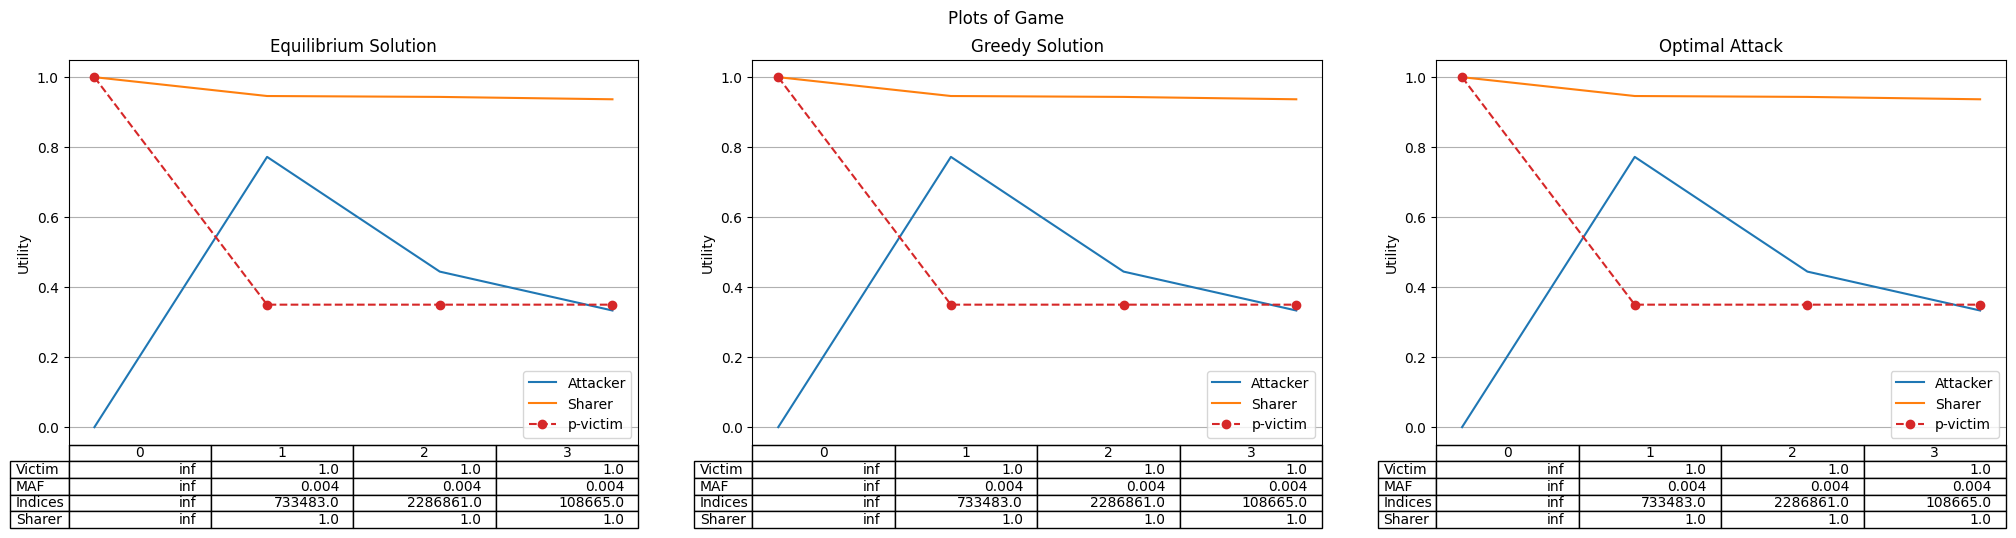

In [58]:
fig = plt.figure(figsize=(25, 5))
su_eq[0], su_grd[0], su_opt[0] = 1, 1, 1

# Figure 1
ax1 = fig.add_subplot(131)
ax1 = create_plot(ax1,"Equilibrium Solution",au_eq,su_eq,a_eq,s_eq, pv_eq)

# Figure 2
ax2 = fig.add_subplot(132)
ax2 = create_plot(ax2,"Greedy Solution",au_grd,su_grd,a_grd,s_grd, pv_grd)

# Figure 3
ax3 = fig.add_subplot(133)
ax3 = create_plot(ax3,"Optimal Attack",au_opt,su_opt,a_opt,s_opt, pv_opt)

fig.suptitle('Plots of Game')
plt.show()
#fig.savefig("6queery3.png", dpi=500, bbox_inches="tight", pad_inches=1)

## LRT Experiments

In [ ]:
error=0.001
def calculate_lrt(num_people, response, genome, maf):
    DN_i = np.power((1-maf), (2*num_people))
    DN_i_1 = np.power((1-maf), (2*num_people-2))
    
    # Genome == 1
    log1 = np.log(DN_i/(error*DN_i_1))
    log2 = np.log((error*DN_i_1 * (1-DN_i)) / (DN_i * (1-error*DN_i_1)))
    
    # Genome == 0
    log3 = np.log(DN_i)-np.log(((1-error)*DN_i_1))
    log4 = np.log(1-error) + np.log(DN_i_1) + np.log(1-DN_i) - (    np.log(DN_i) + np.log(1-DN_i_1*(1-error))    )  
    print("Log1: ", log1, "\nLog2: ", log2, "\nLog3: ", log3, "\nLog4: ", log4, "\n\n")
    return  (log1+log2*response) * genome.T + (log3+log4*response) * (1-genome).T

temp = calculate_lrt(60, np.array([0,0,1,1]), np.array([0,1,0,1]), np.array([0.15]*4))

print("Optimal Attack - LRT Values in Attacker's Side")
print("Case where MAF=0.001 and beacon response and genome value is accordingly\n-------------------------------------------------------")
print("Response=0 & Genome=0 --> ", temp[0])
print("Response=0 & Genome=1 --> ", temp[1])
print("Response=1 & Genome=0 --> ", temp[2])
print("Response=1 & Genome=1 --> ", temp[3])

In [ ]:
temp = calculate_lrt(60, np.array([0,1,0,1]), np.array([0,0,1,1]), np.array([0.001,0.001,0.001,0.001]))
print("Optimal Attack - LRT Values in Defender's Side")
print("Case where MAF=0.001 and beacon response and genome value is accordingly\n-------------------------------------------------------")
print("Response=0 & Genome=0 --> ", temp[0])
print("Response=0 & Genome=1 --> NOT VALID")#, temp[1])
print("Response=1 & Genome=0 --> ", temp[2])
print("Response=1 & Genome=1 --> ", temp[3])